In [35]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
from flax import struct
from flax.core import frozen_dict

from tqdm.auto import tqdm
from functools import partial
import optax
#jax.config.update("jax_platform_name", "cpu")
jax.devices()


[cuda(id=0)]

In [36]:
import frozen_lake
import utils
import policies

In [37]:
rng_key = jax.random.PRNGKey(42)

# initialize env
env = frozen_lake.FrozenLake((4, 4))
rng_key, rng_env_init = jax.random.split(rng_key)
env_params = env.init(rng_env_init)

# create example obs to initialize policy
rng_key, rng_reset, rng_obs = jax.random.split(rng_key, 3)
env_state = env.reset(rng_reset, env_params)
env_obs = env.get_obs(rng_obs, env_state, env_params)
mock_data = (jax.random.PRNGKey(42), env_obs)

# initialize policy
policy = policies.DQNet([16, 16], 4)
optimizer = optax.adam(1e-3)
rng_key, rng_policy_init = jax.random.split(rng_key)
policy_params = policy.init(rng_policy_init, *mock_data)
optimizer_state = optimizer.init(policy_params)

In [38]:
rollout = jax.jit(partial(utils.rollout, env, policy, steps=1000, env_params=env_params))
grad = jax.grad(partial(utils.loss_fn, policy))

@jax.jit
def train_step(rng_key, policy_params, optimizer_state):
    # rollout
    transitions = rollout(rng_key, policy_params)

    # train
    gradients = grad(policy_params, transitions)
    updates, optimizer_state = optimizer.update(gradients, optimizer_state)
    policy_params = optax.apply_updates(policy_params, updates)
    return policy_params, optimizer_state

  0%|          | 0/1000 [00:00<?, ?it/s]

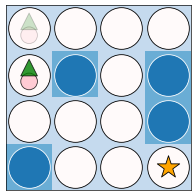

In [39]:
for rng_key in tqdm(jax.random.split(rng_key, 100)):
    policy_params, optimizer_state = train_step(rng_key, policy_params, optimizer_state)

# replace epsilon with 0
policy_params = jax.tree_util.tree_map_with_path(
    lambda path, x: 0.0 if path[-1].key == "epsilon" else x, policy_params
)
transitions = rollout(rng_key, policy_params)
frozen_lake.render(transitions.env_state, env_params)